<h1>Export_rpt.py</h1>
<p>
input: 
Por=np.arange(0.05,0.35,0.01),
Sw=np.arange(0,1.01,0.01),
den_m=2.7639,
Km=43,
Mum=20.3,
Kcri=6.4684,
Mucri=5.6135,
Phic=0.4,
RhoBr=0.97,
RhoOil=0.6,
RhoGas=0.12,
Kbr=2.498,
Kgas=0.0432.</p>
<p>Calculate RPT and export file as RPT_variables.pickle with  RPT_variables.pickle include: P-Impedance,Vp Vs ratio, gradient, Porosity,water saturation</p>

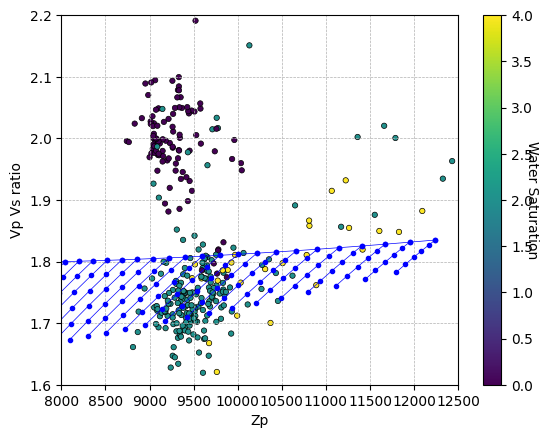

In [1]:
# %load export_rpt.py
import numpy as np
import math
import Kdry_func
import Mu_dry_func
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from mpl_toolkits import mplot3d
import matplotlib.colors as mcolors
from scipy.signal import convolve,lfilter,convolve2d
import sklearn as sk
# import convolution_common as kde_cm
import kernel_2d as kde_2d
from sklearn.neural_network import  MLPRegressor
from sklearn.model_selection import train_test_split
import pickle
Por=np.arange(0.05,0.35,0.01)
Sw=np.arange(0,1.01,0.01)
den_m=2.7639
Km=43
Mum=20.3
Kcri=6.4684
Mucri=5.6135
Phic=0.4
RhoBr=0.97
RhoOil=0.6
RhoGas=0.12
Kbr=2.498
Kgas=0.0432
Kfl_new=np.ones((len(Sw),len(Por)))
Kdry=np.ones((len(Sw),len(Por)))
Musat_rpt=np.ones((len(Sw),len(Por)))
den_fl=np.ones((len(Sw),len(Por)))
den_sat=np.ones((len(Sw),len(Por)))
Ksat_rpt=np.ones((len(Sw),len(Por)))
Vp_new=np.ones((len(Sw),len(Por)))
Vs_new=np.ones((len(Sw),len(Por)))
fl_V=np.ones((len(Sw),len(Por)))
Por_V=np.ones((len(Sw),len(Por)))
for i in range(len(Por)):
    for j in range(len(Sw)):
        Kfl_new[j,i]=(Kbr-Kgas)*Sw[j]**1+Kgas
        Kdry[j,i]=Kdry_func.Kdry_func(Km,Mum,Kcri,Mucri,Phic,Por[i],method='Hash')
        Musat_rpt[j,i]=Mu_dry_func.Mu_dry_func(Km,Mum,Kcri,Mucri,Phic,Por[i],method='Hash')
        Vbr=Sw[j]
        VOil=0
        VGas=(1-Sw[j])
        den_fl=RhoBr*Vbr+RhoOil*VOil+RhoGas*VGas
        den_sat[j,i]=den_fl*Por[i]+den_m*(1-Por[i])
        Ksat_rpt[j,i]=Kdry[j,i]+(1-Kdry[j,i]/Km)**2/(Por[i]/Kfl_new[j,i]+(1-Por[i])/Km-Kdry[j,i]/Km**2)
        Vp_new[j,i]=math.sqrt((Ksat_rpt[j,i]+4/3*Musat_rpt[j,i])*10**6/den_sat[j,i])
        Vs_new[j,i]=math.sqrt(Musat_rpt[j,i]/den_sat[j,i]*10**6)
        fl_V[j, i] = Sw[j]
        Por_V[j, i] = Por[i]
# plot Vp vs zp
df=pd.read_csv('data1.csv',header=0)
df['VpVs ratio']=df['P-wave']/df['S-wave']
df['Zp']=df['P-wave']*df['Density']
colors=df['Water Saturation']
plt.grid(linestyle='--',linewidth = 0.5)
plt.scatter(df['Zp'],df['VpVs ratio'],c=df['Lithology'],s=15,marker='o', edgecolors='black', linewidths=0.5)
plt.xlabel('Zp')
plt.ylabel('Vp Vs ratio')
cbar=plt.colorbar()
cbar.set_label('Water Saturation', rotation=270)
plt.plot(den_sat[-1,:]*Vp_new[-1,:],Vp_new[-1,:]/Vs_new[-1,:],'b-o',linewidth = '0.5',markersize=3)
for i in range(len(Por)):
    condition=np.arange(Vp_new.shape[0])%20==1
    condition[-1]=True
    plt.plot(den_sat[condition,i]*Vp_new[condition,i],Vp_new[condition,i]/Vs_new[condition,i],'b-o',linewidth = '0.5',markersize=3)
plt.ylim([1.6,2.2])
plt.xlim([8000,12500])

# define x, y coordinates

# rpt data
Zp_rpt=(den_sat*Vp_new)
VpVs_rpt=(Vp_new/Vs_new)


# gradient rpt
u=np.ones(Zp_rpt.shape)
v=np.ones(Zp_rpt.shape)
for i in range(len(Por)):
    for j in range(len(Sw)):
        try:
            u[j, i] = Zp_rpt[j, i + 1] - Zp_rpt[j, i]
            v[j, i] = VpVs_rpt[j, i + 1] - VpVs_rpt[j, i]
        except IndexError:
            u[j, i]=u[j, i-1]
            v[j, i]=v[j, i-1]

Zp_rpt=Zp_rpt.ravel()
VpVs_rpt=VpVs_rpt.ravel()
data=np.column_stack((Zp_rpt,VpVs_rpt))
y=np.arctan(v.ravel()/u.ravel())
# Save the variable to a file using pickle
my_var={'zp':Zp_rpt,'VpVs':VpVs_rpt,'actan':y,'Porosity':Por_V,'Sw':fl_V}
with open('RPT_variables.pickle', 'wb') as f:
    pickle.dump(my_var, f)

<h1>gradient_calculate.py</h1>
 <p>Input:RPT_variables.pickle (include varialbes:P-Impedance,Vp Vs ratio, gradient, Porosity,water saturation), log data Vp/Vs, Zp</p>
 <p>Calculate Kernel density estimation, gradient of porosity</p>

[array([[ 3.67867176, -0.5149935 ,  1.0205664 ,  1.68167006, -4.75574398,
         0.25055513, -1.36383243,  1.04221937,  3.64337643,  0.29226901,
         1.46460737, -1.1699388 ,  0.41682702, -2.09285597,  0.0988198 ,
        -1.28193428, -2.61290436,  2.76277821,  3.60705215, -0.16613096,
         2.13157666, -1.70146643, -2.66723908,  4.34175495,  1.16111312,
        -5.41133662, -5.34681778, -0.47929146, -0.38292988, -0.77507963,
         1.59576867,  2.37714299,  1.80682525,  4.58862018, -2.99986792,
         1.75270917,  2.59951948,  2.16737396, -0.46805185, -0.20903866,
         0.31712139, -2.11242152, -0.77000893,  5.16521929, -0.52433302,
         1.50576572,  0.01127961, -2.93712331,  1.48179743, -1.9718042 ],
       [-3.57083188,  0.59868396, -2.70642024, -2.21842474,  4.54023295,
        -1.74326343,  1.37783192, -2.18853589, -3.48156989,  0.60996099,
        -1.07328113,  0.8408159 ,  0.04856665,  1.47149485, -1.56934309,
         1.09227704,  2.56137574, -0.37423578,  0

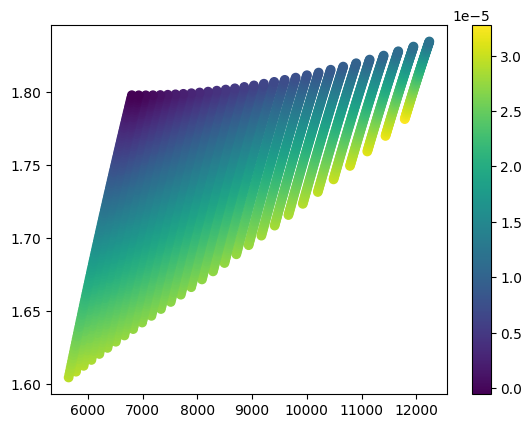

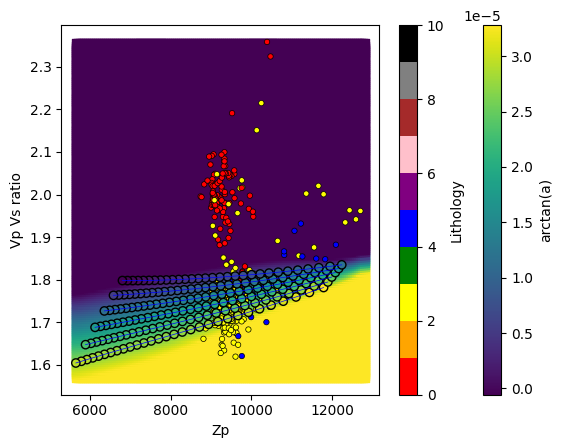

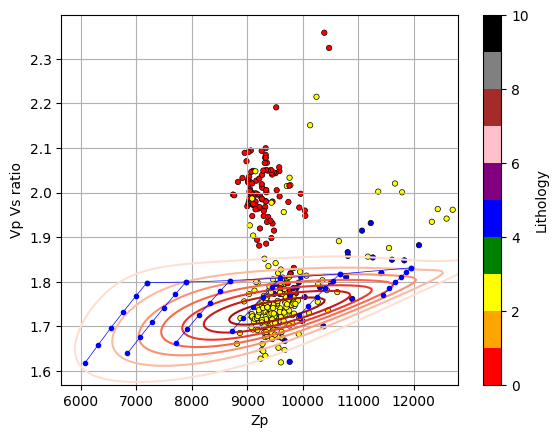

In [2]:
# %load gradient_calculate.py
# %load gradient_calculate.py
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from sklearn.datasets import make_regression
from sklearn.neural_network import MLPRegressor
import pandas as pd
import kernel_2d as kde_2d
import pickle
from sklearn.model_selection import train_test_split
import matplotlib.colors as mcolors
# define colormap for litho
colors = ['red', 'orange', 'yellow', 'green', 'blue', 'purple', 'pink', 'brown', 'gray', 'black']
cmap = plt.cm.colors.ListedColormap(colors)
bounds=[0,1,2,3,4,5,6,7,8,9,10]
norm = mcolors.BoundaryNorm(bounds, cmap.N)
#-------------------------------------------
df=pd.read_csv('data1.csv',header=0)
df['VpVs ratio']=df['P-wave']/df['S-wave']
df['Zp']=df['P-wave']*df['Density']
# colors=df['Water Saturation']
# plt.grid(linestyle='--',linewidth = 0.5)
# plt.scatter(df['Zp'],df['VpVs ratio'],c=df['Lithology'],s=15,marker='o', edgecolors='black', linewidths=0.5)
# load zp vp/vs of rpt
with open('RPT_variables.pickle', 'rb') as f:
    loaded_vars = pickle.load(f)
Zp=loaded_vars['zp']
VpVs=loaded_vars['VpVs']
arctan=loaded_vars['actan']
Por=loaded_vars['Porosity']
Sw=loaded_vars['Sw']

# Generate random data
y = arctan
Zp=Zp/10000
X= np.column_stack((Zp,VpVs))
plt.scatter(X[:,0]*10000,X[:,1],c=y)
plt.colorbar()
X_train, X_test, y_train, y_test = train_test_split(X,y*100000,test_size=0.1,random_state=42)
# Create an MLPRegressor object and fit it to the data
mlp = MLPRegressor(hidden_layer_sizes=(50,2),solver='lbfgs', activation='tanh',random_state=1, learning_rate_init=0.001, max_iter=1000)
mlp.fit(X_train, y_train)
coeff=mlp.coefs_
inter=mlp.intercepts_
y_pred=mlp.predict(X_test)
mse = np.mean((y_pred - y_test)**2)
print(mlp.coefs_)
print(mlp.intercepts_)
print("Accuracy on training set: {:.5f}".format(mlp.score(X_train, y_train)))
print("Accuracy on test set: {:.5f}".format(mlp.score(X_test, y_test)))
# Create a meshgrid of feature values
# x1_min, x1_max = X[:, 0].min() , X[:, 0].max()
# x2_min, x2_max = X[:, 1].min() , X[:, 1].max()
x1_min, x1_max = np.min(Zp) , np.max(df['Zp']/10000)
x2_min, x2_max = np.min(df['VpVs ratio']) , np.max(df['VpVs ratio'])
# x = np.linspace(np.min(Zp), np.max(df['Zp']), 100)
# y = np.linspace(np.min(df['VpVs ratio']), np.max(df['VpVs ratio']), 100)
# xx1,xx2= np.meshgrid(x, y)
xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max+0.01, 0.005), np.arange(x2_min-0.05, x2_max, 0.005))
XX = np.column_stack((xx1.ravel(), xx2.ravel()))

# Predict the output for the meshgrid
y_pred = mlp.predict(XX)

# Reshape the predictions and meshgrid arrays
atanGrad = np.reshape(y_pred, xx1.shape)/100000
fig=plt.figure()
plt.scatter(xx1*10000,xx2,c=atanGrad,marker='s',cmap='viridis',vmin=np.min(y),vmax=np.max(y))
Zp=Zp*10000
Zp=np.reshape(Zp,Por.shape)
VpVs=np.reshape(VpVs,Por.shape)
# plt.plot(Zp[-1,:],VpVs[-1,:],'b-o',linewidth = '0.5',markersize=3)
# plt.scatter(X[:,0]*10000,X[:,1],c=y,edgecolors='black')
f1=plt.scatter(df['Zp'],df['VpVs ratio'],c=df['Lithology'],s=15,cmap=cmap,norm=norm,marker='o', edgecolors='black', linewidths=0.5)

for i in range(Sw.shape[0]):
    # plt.plot(Zp[:,i],VpVs[:,i],'b-o',linewidth = '0.5',markersize=3)
        if i%20==0:
            plt.plot(Zp[i, :], VpVs[i, :], 'b-', linewidth='0.5', markersize=3)
            f2=plt.scatter(Zp[i,:],VpVs[i,:],c=y.reshape(Zp.shape)[i,:],edgecolors='black',cmap='viridis',vmin=np.min(y),vmax=np.max(y))

plt.xlabel('Zp')
plt.ylabel('Vp Vs ratio')
cbar=plt.colorbar(f2)
cbar.set_label('arctan(a)')
cbar1=plt.colorbar(f1)
cbar1.set_label('Lithology')

# Create a 3D plot of the predictions
# fig = plt.figure(figsize=(10, 8))
# ax = plt.axes(projection='3d')
# ax.plot_surface(xx1*10000, xx2, yy, cmap='viridis')
# ax.set_xlabel('X1')
# ax.set_ylabel('X2')
# ax.set_zlabel('Y')
data=df[['Zp','VpVs ratio']].to_numpy()
a=kde_2d.Kernel()
hx = np.std(df['Zp']) / 2 / len(df['Zp']) ** (1 / 6)
hy = np.std(df['VpVs ratio']) / 2 / len(df['VpVs ratio']) ** (1 / 6)
grid=np.vstack((xx1.ravel()*10000,xx2.ravel()))
a.fit(data[df['Lithology']!=0])
result=np.array(a.kernel_2d(grid.T,1/(15*hx)**2,1/(hy)**2,-atanGrad.ravel()))
plt.figure()

plt.scatter(df['Zp'],df['VpVs ratio'],c=df['Lithology'],cmap=cmap,norm=norm,s=15,marker='o', edgecolors='black', linewidths=0.5)
plt.colorbar().set_label('Lithology')
plt.contour(xx1*10000,xx2,result.reshape(xx1.shape),cmap='Reds')
dk1=np.arange(0,Zp.shape[1],1)%5==1

plt.plot(Zp[-1,dk1],VpVs[-1,dk1],'b-o',linewidth = '0.5',markersize=3)

for i in range(Por.shape[1]):
    dk=np.arange(0,Zp.shape[0],1)%20==1
    dk[-1]=True
    if i%5==1:
        plt.plot(Zp[dk, i], VpVs[dk, i], 'b-o', linewidth='0.5', markersize=3)
    # plt.scatter(Zp[:,i],VpVs[:,i],c=y.reshape(Zp.shape)[:,i],edgecolors='black')
plt.xlabel('Zp')
plt.ylabel('Vp Vs ratio')
plt.grid()
# save gradient result
with open('output_grad_cal.pickle','wb') as f:
    pickle.dump({'xx':xx1*10000,'yy':xx2,'mlp':mlp},f)
# df1=pd.DataFrame({'coef':coeff,'inter':inter})
# df2=pd.DataFrame({'xx':xx1,'yy':xx2})
plt.show()


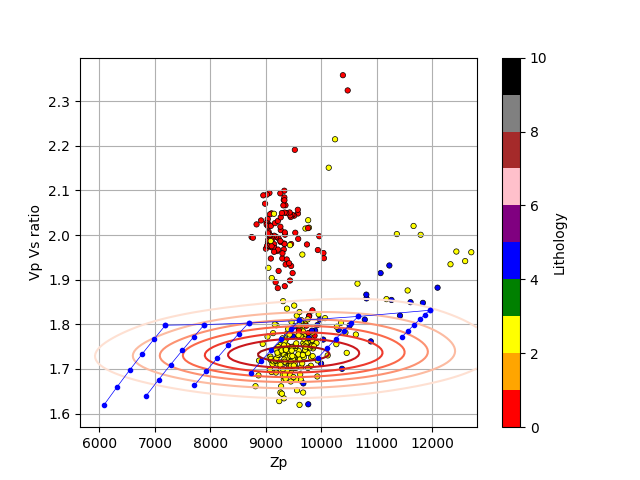

In [3]:
from IPython import display
display.Image("Figure_3.png")

<h1>Prosity_pred_mlp_test.py</h1>
<p>Predict prosity based on MLP method</p>
<p>Input: log data, RPT_variables.pickle, output_grad_cal.pickle</p>

Bóc tách code

In [4]:
#%load Prosity_pred_mlp_test.py
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from sklearn.datasets import make_regression
from sklearn.neural_network import MLPRegressor
import pandas as pd
import kernel_2d as kde_2d
import pickle
from sklearn.model_selection import train_test_split
import matplotlib.colors as mcolors
import scipy.optimize
from sklearn.metrics import r2_score
from scipy.interpolate import griddata
from sklearn import preprocessing
import jdc 


<h2>Prepare data</h2>

In [5]:
#-------------------------------------------
df=pd.read_csv('D:\Tai Lieu\OneDrive - Hanoi University of Science and Technology\Desktop\data1.csv',header=0)
df['VpVs ratio']=df['P-wave']/df['S-wave']
df['Zp']=df['P-wave']*df['Density']
with open('RPT_variables.pickle', 'rb') as f:
    loaded_vars = pickle.load(f)
Zp_rpt=loaded_vars['zp']
VpVs_rpt=loaded_vars['VpVs']
arctan_rpt=loaded_vars['actan']
Por_rpt=loaded_vars['Porosity']

Sw_rpt=loaded_vars['Sw']
with open('output_grad_cal.pickle','rb') as f:
    load_vars=pickle.load(f)
mlp_grad=load_vars['mlp']

Por=df['Porosity']
# [df['Lithology']!=0]
# [df['Lithology']!=0]
xx=load_vars['xx']
yy=load_vars['yy']
# grad_pre=mlp_grad.predict(np.column_stack((df['Zp'].to_numpy()/10000,df['VpVs ratio'].to_numpy())))
X=df[['Zp','VpVs ratio']]
# [df['Lithology']!=0]
# [df['Lithology']!=0]
# Y=np.vstack((Por,grad_pre)).T
# calculate gradient of RPT--------------------
t=griddata((Zp_rpt,VpVs_rpt),Por_rpt.ravel(),(xx,yy), method='linear')
gradx = np.gradient(t, axis=1)
grady = np.gradient(t, axis=0)
grad_pred=np.arctan(grady/gradx)
grad_pred[np.isnan(grad_pred)]=0
grad_por_rpt=griddata((xx.ravel(),yy.ravel()),grad_pred.ravel(),(X.iloc[:,[0,1]]), method='linear')
grad_por_rpt[np.isnan(grad_por_rpt)]=0
#---------------------------------------
Y=np.vstack((Por,grad_por_rpt)).T 
# [(df['Lithology']!=0).to_numpy().any(axis=1)]
#------- add data rpt----------
# X=np.vstack((np.column_stack((Zp_rpt/10000,VpVs_rpt)),X.values))
# Y=np.vstack((np.column_stack((Por_rpt.ravel(),arctan_rpt*100000)),Y))
#---------------------------
X_train, X_test, y_train, y_test = train_test_split(X,Y[:,0][:,np.newaxis],test_size=0.1,random_state=42)
t=griddata((Zp_rpt,VpVs_rpt),Por_rpt.ravel(),(xx,yy), method='linear')

<h2>Class MLP</h2>
<h3>__init__ function inits the number of layers and units in each layer</h3>

In [6]:

class MLP:
    

    def __init__(self, input_size, hidden_sizes, output_size,random_state=1): 
        self.input_size = input_size
        self.hidden_sizes = hidden_sizes
        self.output_size = output_size
        self.Ws = []
        self.bs = []
        np.random.seed(random_state)
        count=0
        self.W=None
        bias=None
        for i in range(len(hidden_sizes)):
            if i==0:
                count+=input_size*hidden_sizes[i]
                count+=hidden_sizes[i]
                # self.W=self.initialize_weights(self.input_size,hidden_sizes[i]).ravel()
                self.W=self._init_coef(self.input_size,hidden_sizes[i])[0].ravel()
                bias=self._init_coef(self.input_size,hidden_sizes[i])[1].ravel()
            if i!=0:
                count+=hidden_sizes[i-1]*hidden_sizes[i]
                count += hidden_sizes[i]
                self.W=np.concatenate((self.W,self._init_coef(self.hidden_sizes[i-1],hidden_sizes[i])[0].ravel()),axis=None)
                bias=np.concatenate((bias,self._init_coef(self.hidden_sizes[i-1],hidden_sizes[i])[1].ravel()),axis=None)
        self.W=np.concatenate((self.W,self._init_coef(self.hidden_sizes[i],output_size)[0].ravel()),axis=None)
        bias=np.concatenate((bias,self._init_coef(self.hidden_sizes[i],output_size)[1].ravel()))
        self.W=np.concatenate((self.W,bias),axis=0)
        count+=output_size*hidden_sizes[-1]
        count+=output_size
        # self.W = np.concatenate((self.W, 1*np.ones((1, count - len(self.W)))),axis=None)
        # self.W=np.random.randn(count)

        for i in range(len(hidden_sizes)):
            if i == 0:
                self.Ws.append(np.random.randn(self.input_size, self.hidden_sizes[i]))
            else:
                self.Ws.append(np.random.randn(self.hidden_sizes[i-1], self.hidden_sizes[i]))
            self.bs.append(np.zeros((1, self.hidden_sizes[i])))
        self.Ws.append(np.random.randn(self.hidden_sizes[-1], self.output_size))
        self.bs.append(np.zeros((1, self.output_size)))
        self.bias=bias


<h3>Create model</h3>

In [7]:
# # create model 
# mlp=MLP(2,(5,),1,random_state=1) # 2 input, 5 units in hidden layer,1 output
# print('ws=',mlp.Ws)  # init weight
# print('bias=',mlp.bias)  # init bias

<h3>initialize_weights function init weights with recommended of  Glorot et al.</h3>

In [8]:
%%add_to MLP    
def initialize_weights(self,n_in, n_out):
        #this function init weights with recommended of  Glorot et al.
        variance = 6 / (n_in + n_out)
        stddev = np.sqrt(variance)
        weights = np.random.normal(loc=0.0, scale=stddev, size=(n_in, n_out))
        return weights


In [9]:
# mlp.initialize_weights(4,3)

<h3>initialize_weights function </h3>
<p>init coffient (bias) with recommended of  Glorot et al.</p>

In [10]:
%%add_to MLP
def _init_coef(self, fan_in, fan_out):
    # Use the initialization method recommended by
    # Glorot et al.
    factor = 6.0
    # if self.activation == "logistic":
    #     factor = 2.0
    init_bound = np.sqrt(factor / (fan_in + fan_out))

    # Generate weights and bias:
    coef_init = np.random.uniform(-init_bound, init_bound, (fan_in, fan_out))
    intercept_init = np.random.uniform(-init_bound, init_bound, fan_out)
    return coef_init, intercept_init
 

In [11]:
# mlp._init_coef(4,3)

<h3>tanh(x),linear(x) </h3>
<p>Play roles as activation functions in forward function</p>

In [12]:
%%add_to MLP
def tanh(self, x): # activation function
    return np.tanh(x)
def linear(self, x): 
    return x  

In [13]:
# mlp.linear(7)

In [14]:
# mlp.tanh(5)

<h3>forward function </h3>
<p>Give output of MLP model with X: input data</p>

In [15]:
%%add_to MLP
def forward(self,X): 
    # this function give output of model with X: input data
    # for example: 
    # mlp=MLP(2,(5,),1,random_state=1)
    # mlp.forward([6000,1.6]) #zp=6000, vp/vs=1.6
    # Output: array([[-0.03180565]])
    self.zs = []
    self.as_ = [X]
    for i in range(len(self.Ws)):
        z = np.dot(self.as_[-1], self.Ws[i]) + self.bs[i]
        if i == len(self.Ws) - 1:
            a = self.linear(z)
        else:
            a = self.tanh(z)
        self.zs.append(z)
        self.as_.append(a)
    # self.W=W
    return self.as_[-1]

In [16]:
# mlp.forward([6000,1.6]) #zp=6000, vp/vs=1.6

<h3>update_weights function</h3>
<p>Update weights and bias after optimization</p>

In [17]:
%%add_to MLP
def update_weights(self,W):
    # this function update weights and bias after optimization
    Ws = []
    bs = []
    tmp = 0
    for i in range(len(self.Ws)):
        Ws.append(W[tmp:tmp + self.Ws[i].size].reshape(self.Ws[i].shape))
        tmp += self.Ws[i].size
    for i in range(len(self.bs)):
        bs.append(W[tmp:tmp + self.bs[i].size].reshape(self.bs[i].shape))
        tmp += self.bs[i].size
    self.Ws = Ws
    self.bs = bs



In [18]:
# test_w=np.random.randn(21)
# print('W=',test_w)
# mlp.update_weights(test_w)
# print('ws=',mlp.Ws)
# print('bias=',mlp.bias)  

<h3>mse_loss function</h3>
<p>This function modified to suit with model prosity predict plays a role as a part of cost function. Input y_pre: prosity predicted from MLP, y_true: prosity of log</p>

In [19]:
%%add_to MLP
def mse_loss(self, y_true, y_pred): # this function modified suitable with predicting prosity problem
    # gradient with model
    x, y = self.xx_norm, self.yy_norm
    # zz_model = griddata((self.xx.ravel(), self.yy.ravel()), self.forward(np.column_stack((self.xx.ravel(),self.yy.ravel())))[:,0],
    #                     (x,y), method='linear')
    # input_rpt=np.column_stack((self.rpt_zp_norm.ravel(), self.rpt_vpvs_norm.ravel()))
    input_rpt = np.column_stack((self.xx_norm.ravel(), self.yy_norm.ravel()))
    # input_rpt=np.column_stack((input_rpt, np.ones((input_rpt.shape[0],1))))
    zz_model = self.forward(input_rpt)[:, 0].reshape(x.shape)

    # zz_model =self.forward(input_rpt)[:,0]
    # zz_grid_model= griddata((self.rpt_zp_norm.ravel(), self.rpt_vpvs_norm.ravel()),zz_model,(x,y),method='linear')
    gradx = np.gradient(zz_model, axis=1)
    grady = np.gradient(zz_model, axis=0)
    arctan_model = np.arctan(grady / gradx)
    # arctan_model[self.arctan_rpt_norm==0]=0
    # y_grad_pred=griddata((x.ravel(),y.ravel()),arctan_model.ravel(),(self.X_norm),method='linear')
    # y_grad_pred[np.isnan(y_grad_pred)]=0
    # y_grad_true=griddata((x.ravel(),y.ravel()),self.arctan_rpt_norm.ravel(),(self.X_norm),method='linear')
    grad_model = np.sqrt(gradx ** 2 + grady ** 2)
    # grad_model[self.arctan_rpt_norm==0]=0

    # plt.scatter(x,y,c=self.grad_rpt,vmin=np.min(self.grad_rpt),vmax=np.max(self.grad_rpt))
    # plt.colorbar()
    # plt.show()
    # Add L2 regularization term to loss
    # zz_model[self.rpt_por_norm == 0] = 0
    values = 0
    loss=0
    n_samples=self.X.shape[0]
    for s in self.Ws:
        s = s.ravel()

        values += np.dot(s, s)

    loss += (0.5 * 0.0001) * values / n_samples
    loss = loss+ 10*np.mean((y_true - y_pred) ** 2) #+5*np.mean((zz_model-self.rpt_por_norm)**2)
    loss+=15*np.mean((self.arctan_rpt_norm.ravel()-arctan_model.ravel())**2)#+10000*np.mean((grad_model.ravel() - self.grad_amp_por_norm.ravel())**2)
    # loss=loss+np.mean((y_true-y_pred)**2)+np.mean((y_grad_pred-self.y_grad_true)**2)
    # self.zz=zz_model
    return loss


In [20]:
# mlp.mse_loss(y_train,mlp.forward(X_train))

<h3>cost_function</h3>
<p>This function used for optimization in backward function</p>

In [21]:
%%add_to MLP       
def cost_function(self,W,X,y_true): # W:total weights and bias, X: input, y_true: output data
    Ws = []
    bs = []
    tmp = 0
    for i in range(len(self.Ws)):
        Ws.append(W[tmp:tmp + self.Ws[i].size].reshape(self.Ws[i].shape))
        tmp += self.Ws[i].size
    for i in range(len(self.bs)):
        bs.append(W[tmp:tmp + self.bs[i].size].reshape(self.bs[i].shape))
        tmp += self.bs[i].size
    self.Ws=Ws
    self.bs=bs
    self.W=W
    y_pred=self.forward(X)
    return self.mse_loss(y_true,y_pred)

In [22]:

# mlp.cost_function(mlp.W,X_train,y_train)

<h3>backward function</h3>
<p>Optimize weights and bias of MLP model to fit with data log</p>

In [23]:
%%add_to MLP
def backward(self, X, y):
    # this function active after fit function called
    # using attribute and method in this class to optimize weights and bias of modeld
    obj_func=lambda W: self.cost_function(W,X,y)

    result= scipy.optimize.minimize(obj_func, self.W,method='L-BFGS-B')



    # result = scipy.optimize.minimize(obj_func, self.W, method='Nelder-Mead',options={'maxiter':1000})
    # minimizer_kwargs = {"method": "BFGS"}
    # result = scipy.optimize.basinhopping(obj_func, self.W,  minimizer_kwargs=minimizer_kwargs, niter=200)
    self.W=result.x
    self.update_weights(self.W)
    


In [24]:
# mlp.backward(X_train,y_train)

<h3>fit function</h3>
<p>Define input datas for calculating all function, run backward function to fit model with data. In pracice, it only calls __init__ function and this function to training model</p>

In [25]:
%%add_to MLP   
def fit(self, X, y,rpt_por,rpt_zp,rpt_vpvs,xx,yy, learning_rate=0.01, num_epochs=1, verbose=True):
        #fit model with data, this function has inputs include X: input data, y: output data, rpt_por,rpt_zp,rpt_vpvs: data of RPT; xx,yy: grid domain: support to calculate gradient
        # It will normalize data and then run optimization model (backward) for predict data

        self.learning_rate = learning_rate
        self.num_epochs = num_epochs
        self.X=X
        self.y=y
        self.xx=xx
        self.yy=yy
        self.rpt_por=rpt_por
        self.rpt_zp=rpt_zp
        self.rpt_vpvs=rpt_vpvs
        self.gradx_rpt = np.gradient(self.rpt_por, axis=1)
        self.grady_rpt = np.gradient(self.rpt_por, axis=0)
        self.arctan_rpt = np.arctan(self.grady_rpt / self.gradx_rpt)/np.linalg.norm(np.arctan(self.grady_rpt / self.gradx_rpt))
        self.arctan_rpt[np.isnan(self.arctan_rpt)] = 0
        self.grad_rpt = np.sqrt(self.gradx_rpt ** 2 + self.grady_rpt ** 2)/np.linalg.norm(np.sqrt(self.gradx_rpt ** 2 + self.grady_rpt ** 2))
        self.grad_rpt[np.isnan(self.grad_rpt)] = 0
        # normalize data
        X=X.to_numpy()
        self.X_norm=np.ones(X.shape)

        self.X_norm[:,0]=X[:,0]/10000
        self.X_norm[:,1]=X[:,1]

        self.y_norm = np.ones(y.shape)
        for i in range(y.shape[1]):
            self.y_norm[:,i]=y[:,i]#/np.linalg.norm(y[:,i])
        self.rpt_zp_norm=self.rpt_zp/np.linalg.norm(self.rpt_zp)
        self.rpt_vpvs_norm=self.rpt_vpvs/np.linalg.norm(self.rpt_vpvs)
        self.rpt_por_norm=self.rpt_por#/np.linalg.norm(self.y[:,0])
        self.gradx_rpt_norm = np.gradient(self.rpt_por_norm, axis=1)
        self.grady_rpt_norm = np.gradient(self.rpt_por_norm, axis=0)
        self.arctan_rpt_norm = np.arctan(self.grady_rpt_norm / self.gradx_rpt_norm)
        self.arctan_rpt_norm[np.isnan(self.arctan_rpt_norm)]=0
        self.grad_amp_por_norm=np.sqrt(self.gradx_rpt_norm**2+self.grady_rpt_norm**2)
        self.grad_amp_por_norm[np.isnan(self.grad_amp_por_norm)]=0
        self.rpt_por_norm[np.isnan(self.rpt_por_norm)]=0
        self.xx_norm = xx/10000 #/np.linalg.norm(X[:,0])
        self.yy_norm = yy #/np.linalg.norm(X[:,1])
        # self.y_grad_true = griddata((self.xx_norm.ravel(), self.yy_norm.ravel()), self.arctan_rpt_norm.ravel(), (self.X_norm), method='linear')
        # self.y_grad_true[np.isnan(self.y_grad_true)]=0
        for i in range(num_epochs):
            self.backward(self.X_norm, self.y_norm) 
            y_pred = self.forward(self.X_norm)
            loss = self.mse_loss(self.y_norm, y_pred)
            if verbose:
                print('Epoch %d, loss = %.4f' % (i, loss))
        return self


In [26]:
# mlp.fit(X_train,y_train,t,Zp_rpt,VpVs_rpt,xx,yy)

<h3>predict function</h3>
<p>Called after training model to predict porosity</p>

In [27]:
%%add_to MLP
def predict(self, X):
    X[:,0]=X[:,0]/10000
    result=np.ones((X.shape[0],self.y.shape[1]))
    for i in range(self.y.shape[1]):
        result[:,i]=self.forward(X)[:,i]#*np.linalg.norm(self.y[:,i])
    return result    


In [28]:
# mlp.predict(np.array([[6000,1.6]]))

<h3>Apply Hai Thach project</h3>

In [29]:

# define colormap for litho
colors = ['red', 'orange', 'yellow', 'green', 'blue', 'purple', 'pink', 'brown', 'gray', 'black']
cmap = plt.cm.colors.ListedColormap(colors)
bounds=[0,1,2,3,4,5,6,7,8,9,10]
norm = mcolors.BoundaryNorm(bounds, cmap.N)
#-------------------------------------------
df=pd.read_csv('D:\Tai Lieu\OneDrive - Hanoi University of Science and Technology\Desktop\data1.csv',header=0)
df['VpVs ratio']=df['P-wave']/df['S-wave']
df['Zp']=df['P-wave']*df['Density']
with open('RPT_variables.pickle', 'rb') as f:
    loaded_vars = pickle.load(f)
Zp_rpt=loaded_vars['zp']
VpVs_rpt=loaded_vars['VpVs']
arctan_rpt=loaded_vars['actan']
Por_rpt=loaded_vars['Porosity']

Sw_rpt=loaded_vars['Sw']
with open('output_grad_cal.pickle','rb') as f:
    load_vars=pickle.load(f)
mlp_grad=load_vars['mlp']

Por=df['Porosity']
# [df['Lithology']!=0]
# [df['Lithology']!=0]
xx=load_vars['xx']
yy=load_vars['yy']
# grad_pre=mlp_grad.predict(np.column_stack((df['Zp'].to_numpy()/10000,df['VpVs ratio'].to_numpy())))
X=df[['Zp','VpVs ratio']]
# [df['Lithology']!=0]
# [df['Lithology']!=0]
# Y=np.vstack((Por,grad_pre)).T
# calculate gradient of RPT--------------------
t=griddata((Zp_rpt,VpVs_rpt),Por_rpt.ravel(),(xx,yy), method='linear')
gradx = np.gradient(t, axis=1)
grady = np.gradient(t, axis=0)
grad_pred=np.arctan(grady/gradx)
grad_pred[np.isnan(grad_pred)]=0
grad_por_rpt=griddata((xx.ravel(),yy.ravel()),grad_pred.ravel(),(X.iloc[:,[0,1]]), method='linear')
grad_por_rpt[np.isnan(grad_por_rpt)]=0
#---------------------------------------
Y=np.vstack((Por,grad_por_rpt)).T 
# [(df['Lithology']!=0).to_numpy().any(axis=1)]
#------- add data rpt----------
# X=np.vstack((np.column_stack((Zp_rpt/10000,VpVs_rpt)),X.values))
# Y=np.vstack((np.column_stack((Por_rpt.ravel(),arctan_rpt*100000)),Y))
#---------------------------
X_train, X_test, y_train, y_test = train_test_split(X,Y[:,0][:,np.newaxis],test_size=0.1,random_state=42)
mlp=MLP(2,(5,),1,random_state=1)

t=griddata((Zp_rpt,VpVs_rpt),Por_rpt.ravel(),(xx,yy), method='linear')
mlp.fit(X_train,y_train,t,Zp_rpt,VpVs_rpt,xx,yy)
y_pred=mlp.predict(X_test.to_numpy())
r2 = r2_score(y_test[:,0], y_pred[:,0])
# r2_1=r2_score(y_test[:,1], y_pred[:,1])
print('R2 score prosity:', r2)
zz=mlp.predict(np.column_stack((xx.ravel(),yy.ravel()))).reshape(xx.shape)


Epoch 0, loss = 0.4962
R2 score prosity: -0.0033435698260528834


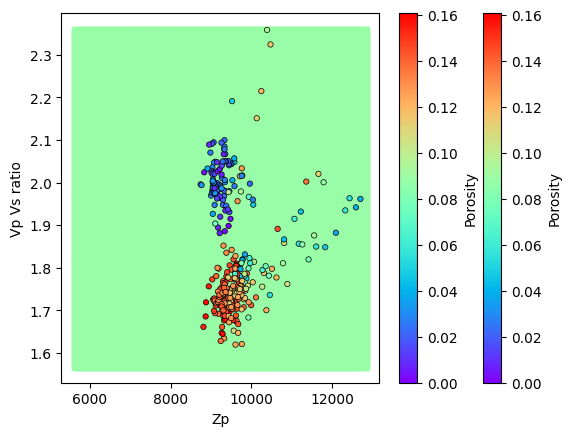

In [30]:

plt.figure()
# ax=plt.axes(projection='3d')
# ax.plot_surface(xx,yy,zz,cmap='rainbow')
h1=plt.scatter(xx,yy,c=zz,marker='s',cmap='rainbow',vmin=df['Porosity'].min(),vmax=df['Porosity'].max())
plt.colorbar(h1).set_label('Porosity')
# for i in range(Por_rpt.shape[1]):
#     # plt.plot(Zp_rpt.reshape(Por_rpt.shape)[:,i],VpVs_rpt.reshape(Por_rpt.shape)[:,i],'b-o',linewidth = '0.5',markersize=3)
#     if i%2==0:
#         plt.plot(Zp_rpt.reshape(Por_rpt.shape)[:, i], VpVs_rpt.reshape(Por_rpt.shape)[:, i], 'b-', linewidth='0.5', markersize=3)
h2=plt.scatter(df['Zp'],df['VpVs ratio'],c=df['Porosity'],cmap='rainbow',s=15,marker='o', edgecolors='black', linewidths=0.5,vmin=df['Porosity'].min(),vmax=df['Porosity'].max())
plt.colorbar(h2).set_label('Porosity')
plt.xlabel('Zp')
plt.ylabel('Vp Vs ratio')
plt.show()

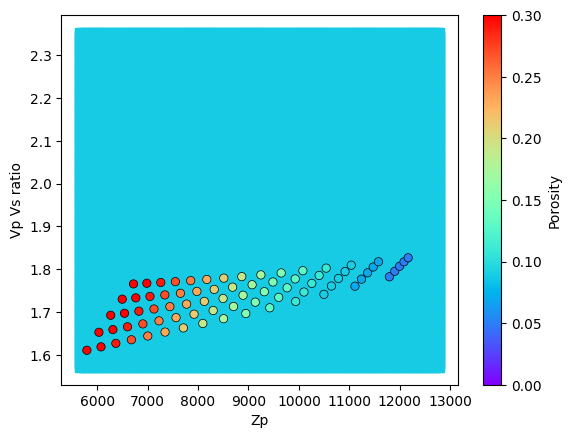

In [31]:
plt.figure()
# ax=plt.axes(projection='3d')
# ax.plot_surface(xx,yy,zz,cmap='rainbow')
h1=plt.scatter(xx,yy,c=zz,marker='s',cmap='rainbow',vmin=df['Porosity'].min(),vmax=0.3)
# plt.colorbar(h1).set_label('Porosity')
for i in range(Por_rpt.shape[1]):
    dk=np.arange(0,Por_rpt.shape[0],1)%20==1
    
    # plt.plot(Zp_rpt.reshape(Por_rpt.shape)[:,i],VpVs_rpt.reshape(Por_rpt.shape)[:,i],'b-o',linewidth = '0.5',markersize=3)
    if i%2==0:
        # h2=plt.scatter(Zp_rpt.reshape(Por_rpt.shape)[condition,i],VpVs_rpt.reshape(Por_rpt.shape)[condition,i],c=Por_rpt[condition,i],edgecolors='black', linewidths=0.5,cmap='rainbow',vmin=df['Porosity'].min(),vmax=df['Porosity'].max())
        h2=plt.scatter(Zp_rpt.reshape(Por_rpt.shape)[dk,i],VpVs_rpt.reshape(Por_rpt.shape)[dk,i],c=Por_rpt[dk,i],edgecolors='black', linewidths=0.5,cmap='rainbow',vmin=df['Porosity'].min(),vmax=0.3)
    # if i%2==0:
    #     plt.plot(Zp_rpt.reshape(Por_rpt.shape)[:, i], VpVs_rpt.reshape(Por_rpt.shape)[:, i], 'b-', linewidth='0.5', markersize=3)
# h2=plt.scatter(df['Zp'],df['VpVs ratio'],c=df['Porosity'],cmap='rainbow',s=15,marker='o', edgecolors='black', linewidths=0.5,vmin=df['Porosity'].min(),vmax=df['Porosity'].max())
plt.colorbar(h2).set_label('Porosity')
plt.xlabel('Zp')
plt.ylabel('Vp Vs ratio')
plt.show()